# Building a RoBERTa-Classifier 


In this notebook we build a model to classify sentences. The classifier consists of a fully connected layer ont top of a RoBERTa model.

The implemenation is based on:
- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
-https://huggingface.co/transformers/model_doc/bert.html
-https://huggingface.co/transformers/model_doc/roberta.html


## Loading all needed Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/RoBertaCola"

/content/drive/MyDrive/RoBertaCola


In [ ]:
! pip install transformers==3
! pip install tokenizers

     |████████████████████████████████| 757kB 8.4MB/s 
     |████████████████████████████████| 901kB 37.2MB/s 
     |████████████████████████████████| 1.2MB 49.0MB/s 
     |████████████████████████████████| 3.0MB 45.6MB/s 


In [ ]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from google.colab import drive
import random
import pickle
#drive.mount('/content/gdrive')

- Get GPU

In [ ]:
# Get Device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


## Building RoBERTa Classifier Model
Here we use the classical RoBERTa model 'roberta-base'. This might be replaced by more specific pretrained models. 

### Bert specific processing

In [ ]:
# Special RoBERTa mdoe to be used: While slight information might be lost; capitalization in tweets is a neglectable characteristic
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

- Get understanding of the distribution of token sizes for maximal length used in BERT

### Build PyTorch Dataset and DataLoader

In [ ]:
# Data Structure
class SentenceDataset(Dataset):
    def __init__(self, sents, labels, tokenizer, max_len):
        self.sents = sents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, item):
        
        sent = str(self.sents[item])
        label = self.labels[item]

        encoding = tokenizer(sent,
                             truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = 'max_length',
                             max_length=self.max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
      
        return { 'sent': sent, 'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }
# Data Loader
def create_data_loader(sentences, labels, tokenizer, max_len, batch_size):
    ds = SentenceDataset(
        sents=sentences, #.to_numpy()
        labels=labels, #.to_numpy()
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

### Actual Model

In [ ]:
class StyleClassifier(nn.Module):
    def __init__(self, n_classes, drop = 0.3):
        
        super(StyleClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=drop)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

class StyleClassifier_forCluster(nn.Module):
    def __init__(self, n_classes, drop = 0.3):
        
        super(StyleClassifier_forCluster, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=drop)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output), pooled_output

### Define Helper functions

In [ ]:
# This provides just a way to illustrate our confusion matrices in a nice and labeled way
def show_confusion_matrix(confusion_matrix, names = ['Scientific', 'Non-Scientifc'], save_path = None):
  confusion_df = pd.DataFrame(cm, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  if save_path:
    plt.savefig(save_path)
  plt.show()

In [ ]:
def get_predictions(model, data_loader):
  # put to eval mode to disable dropout 
  model = model.eval()

  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
      _, preds = torch.max(outputs, dim=1) # dim BATCH_SIZE x 1

      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values, prediction_probs

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

### Parameter choices
- Set hyper parameters and day of mdoel to be loaded

In [ ]:
import datetime
day = datetime.date(2021, 5, 18)
MAX_LEN = 100 # chosen acccroding to hist above
BATCH_SIZE = 32# tunable hyper parameter
EPOCHS = 2
lr = 1e-5
dropout = 0.3

#data_save_path = f'/content/gdrive/MyDrive/StyleClassifier/models/{day}/RoBERTA_Epochs{EPOCHS}_Bs{BATCH_SIZE}_lr{lr}_drop{dropout}/model_specific_data.pkl'# save model specific data
model_save_path = "BERT_training_data/model_balanced3.pt"
#img_save_path = f'/content/gdrive/MyDrive/StyleClassifier/models/{day}/RoBERTA_Epochs{EPOCHS}_Bs{BATCH_SIZE}_lr{lr}_drop{dropout}/cm.png' # save confusion matrix, should include BERT and hyperparameters in name
#report_save_path = f'/content/gdrive/MyDrive/StyleClassifier/models/{day}/RoBERTA_Epochs{EPOCHS}_Bs{BATCH_SIZE}_lr{lr}_drop{dropout}/report.csv' # save classification report, should include BERT and hyperparameters in name

### Recreate data and LOAD model



In [ ]:
data_t = pd.read_csv("data/in_domain_train.tsv", sep="\t", names = ["code","label", "orig_label", "sentence"])
data_t_2 = pd.read_csv("data/in_domain_dev.tsv", sep="\t", names = ["code","label", "orig_label", "sentence"])
data_t_3 = pd.read_csv("data/out_of_domain_dev.tsv", sep="\t", names = ["code","label", "orig_label", "sentence"])
data_t = pd.concat([data_t, data_t_2,data_t_3]).reset_index(drop = True)

data = tuple(data_t.sentence)
labels = tuple(data_t.label)

### Balance data


1    6742
0    2852
Name: label, dtype: int64


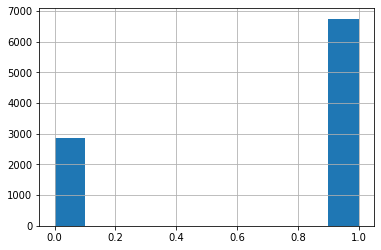

In [ ]:
print(data_t.label.value_counts())
data_t.label.hist()

In [ ]:
# balamce 40/60
#label1 = data_t[data_t.label == 1].sample(4035)
#label2 = data_t[data_t.label == 0]
#data_t = label1.append(label2)
#data_t.label.hist()

#data = tuple(data_t.sentence)
#labels = tuple(data_t.label)

In [ ]:
# Splitting data -> adpat split if necessary
data_train, data_valtest, labels_train, labels_valtest = train_test_split(data, labels, test_size=0.1, random_state = 42) 
data_val, data_test, labels_val, labels_test = train_test_split(data_valtest, labels_valtest, test_size=0.5,random_state = 42) 

assert len(data) == len(data_test)+len(data_train)+len(data_val)

print(f'Number of training sentences: \t {len(data_train)}')
print(f'Number of validation sentences:  {len(data_val)}')
print(f'Number of test sentences: \t {len(data_test)}')

# Create DataLoaders
train_data_loader = create_data_loader(data_train, labels_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, labels_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, labels_test, tokenizer, MAX_LEN, BATCH_SIZE)

for i in range(10):
  print(data_test[i])

Number of training sentences: 	 8634
Number of validation sentences:  480
Number of test sentences: 	 480
The mechanical doll wriggled itself loose.
That the sun was out was obvious.
Which picture of himself does Mary think that John said that Susan likes?
The destruction of the city bothered the Mongols.
A magazine about crime appeared on the newsstands.
Kim likes dogs.
The patient was died.
The horizon was appeared on by a pirate ship.
You please make yourself comfortable and I'll wash the dishes.
John believed that he is honest.


- LOAD MODEL FROM GIVEN PATH


In [ ]:
# LOAD model
model = StyleClassifier(2, drop = dropout).to(device)
model.load_state_dict(torch.load("BERT_training_data/model_balanced3.pt"))
model = model.to(device)

model_cluster = StyleClassifier_forCluster(2, drop = dropout).to(device)
model_cluster.load_state_dict(torch.load("BERT_training_data/model_balanced3.pt"))
model_cluster = model_cluster.to(device)

## Model Evaluation

In [ ]:
# Test Accuracy
test_acc, _ = eval_model(model, test_data_loader, nn.CrossEntropyLoss().to(device) , device, len(data_test))
print(f'Test Accuracy: {test_acc.item()}')

Test Accuracy: 0.86875


- Calculate Scores 

In [ ]:
# Calculation of relevant scores
labels_pred, labels_test,_ = get_predictions(model, test_data_loader)
report = classification_report(labels_test, labels_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()


report_df

,precision,recall,f1-score,support
0,0.790323,0.725926,0.756757,135.00000
1,0.896067,0.924638,0.910128,345.00000
accuracy,0.868750,0.868750,0.868750,0.86875
macro avg,0.843195,0.825282,0.833443,480.00000
weighted avg,0.866327,0.868750,0.866993,480.00000


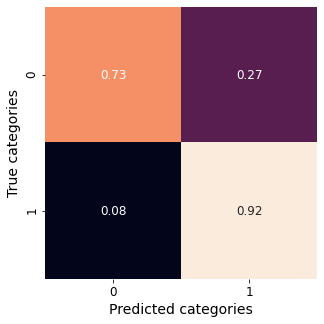

In [ ]:
report_df
cm = confusion_matrix(labels_test, labels_pred, normalize = 'true')
show_confusion_matrix(cm, names = ['0', '1'], save_path=None)

# Analysing the classifier


In [ ]:
pd.set_option('display.max_colwidth', None)
analysis_path = f'/content/drive/MyDrive/RoBertaCola/analysis'

In [ ]:
! mkdir /content/drive/MyDrive/RoBertaCola/analysis

mkdir: cannot create directory ‘/content/drive/MyDrive/RoBertaCola/analysis’: File exists


Working with test data

In [ ]:
# Get Predictions and transfer to list
labels_pred, labels_test, probs = get_predictions(model, test_data_loader)

# Create DF for easier handling!
data = pd.DataFrame(columns = ['sent', 'true_label', 'pred_label'])
data['sent'] = data_test
data['true_label'] = [label.item() for label in labels_test]
data['pred_label'] = [label.item() for label in labels_pred]


#
probs = F.sigmoid(probs)
data['prob0'] = [prob[0].item() for prob in probs]
data['prob1'] = [prob[1].item() for prob in probs]
data['prob_max'] = [max(prob[0].item(),prob[1].item()) for prob in probs]
data.head()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,sent,true_label,pred_label,prob0,prob1,prob_max
0,The mechanical doll wriggled itself loose.,1,1,0.166029,0.846715,0.846715
1,That the sun was out was obvious.,1,1,0.132006,0.869716,0.869716
2,Which picture of himself does Mary think that ...,1,1,0.135886,0.874566,0.874566
3,The destruction of the city bothered the Mongols.,1,1,0.117773,0.883215,0.883215
4,A magazine about crime appeared on the newssta...,1,1,0.118834,0.886235,0.886235


In [ ]:
true_labels = data[data.true_label == data.pred_label]
lengths = [len(tokenizer.tokenize(s)) for s in list(true_labels[true_labels.true_label == 1].sent)]

In [ ]:
data[data.pred_label == 1].true_label.value_counts()

1    319
0     37
Name: true_label, dtype: int64

In [ ]:
cond = (0.45<data['prob0'])*(data['prob0']<0.55)
data_unsure = data.loc[cond]
data_unsure

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,sent,true_label,pred_label,prob0,prob1,prob_max
69,I insist in seeing all the students who started out the term in my class through.,0,1,0.475380,0.501817,0.501817
153,The handle detached from the box.,0,0,0.517208,0.475157,0.517208
206,The train got to the station fully.,1,0,0.506625,0.463175,0.506625
239,I've known more of a man than Frank.,0,0,0.496920,0.490423,0.496920
253,Will George indeed not endorse the treaty?,1,0,0.521174,0.416507,0.521174
300,John is prouder of having gone than John expected me to believe that he wasn't.,0,1,0.451683,0.533043,0.533043
342,Henri told Sue in the drawer that Bill put socks.,0,1,0.482897,0.494634,0.494634
349,I explained it to Bill that she was lying.,1,1,0.474299,0.499084,0.499084
354,Every essay which she's written and that I've read is on that pile.,1,0,0.521944,0.477175,0.521944
373,"He coughed awake and we were all overjoyed, especially Sierra.",1,0,0.524088,0.448519,0.524088


In [ ]:
cond = (data['pred_label'] == 0)*(data['true_label']==1)*(data['prob_max']>0.9)
data_sure = data.loc[cond]

#data_sure.to_csv( analysis_path+'CSArxiv_as_Medium_90.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
cond = (data['pred_label'] == 1)*(data['true_label']==0)*(data['prob_max']>0.9)
data_sure = data.loc[cond]

#data_sure.to_csv( analysis_path+'Medium_as_CSArxiv_90.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
cond = (data['pred_label'] ==0)*(data['true_label'] == 0)*(data['prob_max']>0.9)
data_sure_medium = data.loc[cond]
data_sure_medium['len'] = [len(tokenizer.tokenize(sent)) for sent in data_sure_medium['sent']]
data_sure_medium.head(50)

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sent,true_label,pred_label,prob0,prob1,prob_max,len
6,The patient was died.,0,0,0.904473,0.086234,0.904473,5
13,Brown equipped a camera to Jones.,0,0,0.913493,0.075326,0.913493,7
17,In the box put John the book.,0,0,0.909895,0.088645,0.909895,8
31,John carried to the door.,0,0,0.903083,0.083679,0.903083,6
52,John believes that him is sick.,0,0,0.916432,0.075773,0.916432,7
61,Ten pounds was weighed by the package.,0,0,0.916729,0.078598,0.916729,8
66,This needs investigating the problem.,0,0,0.903414,0.088488,0.903414,6
111,John was seen the book.,0,0,0.910637,0.078114,0.910637,6
132,Mary persuaded that he should rest Bill.,0,0,0.916622,0.074701,0.916622,8
150,John did not leaving here.,0,0,0.913478,0.074867,0.913478,6


In [ ]:
cond = (data['pred_label'] ==1)*(data['true_label'] == 1)*(data['prob_max']>0.9)
data_sure_arxiv = data.loc[cond]
data_sure_arxiv['len'] = [len(tokenizer.tokenize(sent)) for sent in data_sure_arxiv['sent']]
data_sure_arxiv.head(50)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


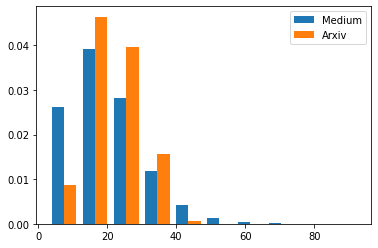

In [ ]:
plt.hist([data_sure_medium['len'], data_sure_arxiv['len']], label = ['Medium', 'Arxiv'], density=True)
plt.legend()
plt.show()

In [ ]:
list_of_rewritten_sents = [
                           ('its vertices are enclosed by the dashed contour.', 'the vertices of this are surrounded by a shaded region.'),
                           ('however, it had never been empirically evaluated before this work.', 'no one has looked at this before in an empirical way.'),
                           ('let us now give a brief description of the concatenated coding scheme.', 'i will now decsribe the the concatenated coding scheme.'),
                           ('let us now give a brief description of the concatenated coding scheme.', 'This now decsribes the the concatenated coding scheme.'),
                           ('given the small difference in performance between the algebraic lattices, it is difficult to propose an optimal candidate.', 'it is very difficult to find an optimum candidate, because the differences are so tiny.'),
                           ('to lower bound the marginal joint replenishment cost we perform a similar analysis to the one in eq.', 'i try to lower bound the cost in the same way as before.'),
                           ('we perform multiple restarts of gradient ascend with random initializations for the nodes ( e ), ( f ), ( g ).', 'the start the optimization from different starting points for the nodes ( e ), ( f ), ( g ).'),
                           ('it is then possible to get an ordered ( from left to right ) overview of the articles on that topic.', 'you can get the overview of the articles on that topic from left to right.'),
                           ('it is then possible to get an ordered ( from left to right ) overview of the articles on that topic.', 'This way one can get the overview of the articles on that topic from left to right.'),
                           ('third, the bandwidths of the network connecting the nodes are limited.', 'also, there is some limitation of the bandwidths of the network.'),
                           ('thus, we obtain the following algorithm for computing the well - founded semantics.', 'We have built this algorithm for finding well - founded semantics.'),
                           ('is result implies that the mean packet delay and delay jitter can go to infinity even if the system is not saturated.', 'this shows cleary that the mean delay and delay jitter can gow super large also when the system is not saturated.'),
                           ('we perform the spectral analysis needed to prove our main result.', 'We do spectral analysis to show that our main result is true.'),
                           ('our focus on these two methods is due to their widespread adoption by the signal processing and statistics communities.', 'we look at these two methods, because they are often used in signal processing and statistics.'),
                           ('furthermore, the combination of friction effects and muscle-pose ambiguity leads to a strong hysteresis effect.', 'also, firction effects and and muscle-pose ambiguity together can result in to strong hysteresis effect.'),
                           ('this will cost large computations to obtain the accurate implicit surface.', 'getting an accurate implicit surface will take long computations.'),
                           ('comparison between the results show that the performance of egc is very close to the performance of oc receiver.', 'looking at the results we cane see that the performance of egc is almost the same as the performance of oc receiver.'),
                           ('the fast convergence of the derived formula is due to the identified mock-gaussian behavior.', 'our formula converges very fast because of the identified mock-gaussian behavior.'),
                           ('we therefore consider scores resulting from algorithms based on editorial changes to be less informative for this comparison.', 'because of this we think that scores from algorithms based on editorial changes are not really good for this comparison.'),
                           ('our work raises a number of questions which aim to further strengthen our understanding of the long term influence.', 'we look at some questions which are supposed to help understnd the long term effects.'),
                           ('of course, the feedback can be substantially reduced by exploiting channel correlations.', 'obviously, you need less feedback if taking into account that there is correlations between the channels.'),
                           ('the proposed optimum solution algorithm is numerically simulated to find the optimum departure region.', 'we simulate the optimum solution algorithm to find the best of the depature regions.'),
                           ('the proposed algorithm is implemented to estimate the wind power output considering practical wind data.', 'our algorithm is built to predict the of wind power using wind data.')

]

In [ ]:
originals = [sent for (sent,_) in list_of_rewritten_sents]
rewritten= [sent for (_,sent) in list_of_rewritten_sents]
print(rewritten)
rewritten_data_loader = create_data_loader(rewritten, [1 for _ in rewritten], tokenizer, MAX_LEN, BATCH_SIZE)
labels_rewritten,_,_ = get_predictions(model, rewritten_data_loader)
print(labels_rewritten)


['the vertices of this are surrounded by a shaded region.', 'no one has looked at this before in an empirical way.', 'i will now decsribe the the concatenated coding scheme.', 'This now decsribes the the concatenated coding scheme.', 'it is very difficult to find an optimum candidate, because the differences are so tiny.', 'i try to lower bound the cost in the same way as before.', 'the start the optimization from different starting points for the nodes ( e ), ( f ), ( g ).', 'you can get the overview of the articles on that topic from left to right.', 'This way one can get the overview of the articles on that topic from left to right.', 'also, there is some limitation of the bandwidths of the network.', 'We have built this algorithm for finding well - founded semantics.', 'this shows cleary that the mean delay and delay jitter can gow super large also when the system is not saturated.', 'We do spectral analysis to show that our main result is true.', 'we look at these two methods, bec

In [ ]:
def show_sentences_with(dataframe, true_label, pred_label, n_sents = 10):

  # Copy dataframe and shuffle to get random sentences
  df = dataframe.copy()
  df = df.sample(frac=1, random_state = 42).reset_index(drop=True)
  #print(df.head())

  count = 0
  for i, (sent, true, pred) in enumerate(zip(df['sent'], df['true_label'], df['pred_label'])):

    if true == true_label and pred == pred_label:
      print(f'True Label:',{1: 'Sci:', 0: 'NonSci'}[true], 'Predicted: ', {1: 'Sci:', 0: 'NonSci'}[pred])
      print('\t', sent, '\n')
      count +=1

    if count > n_sents:
      break

  if count == 0:
    print('Combination not found!')

## Some examples of misclassified and correctly classified sentences to get an understanding of the behaviour of the classifier


## Quantitive differences between the classes

In [ ]:
# Avg length
data['token_length'] = [len(tokenizer.tokenize(sent)) for sent in data['sent']]
data.head()

,sent,true_label,pred_label,prob0,prob1,prob_max,token_length
0,separate arguments as regards the basis processes (exponential inequalities) and the size of the non-random coefficients are combined.,1,1,0.061154,0.949370,0.949370,25
1,this is a non-commutative lie (and thus continuous) group.,1,1,0.126318,0.908063,0.908063,16
2,the third feature set is made up of co-occurrence features that represent words that occur on the immediate left or right of the target word.,1,1,0.275430,0.807936,0.807936,29
3,we define the replicator dynamics in any dimension.,1,1,0.078625,0.933996,0.933996,10
4,"a big oil company put a problem to data scientists: they were to watch if the truck drivers followed safety instructions while transporting gasoline (in particular, if they smoked in the cabin).",0,0,0.952844,0.065087,0.952844,36


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


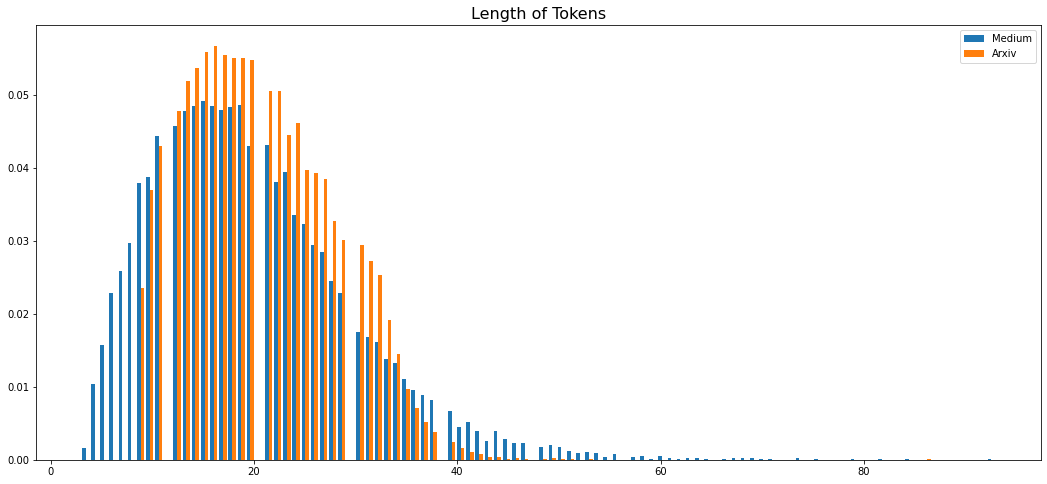

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (18,8))
ax.hist([data['token_length'][data['true_label']==0], data['token_length'][data['true_label']==1]], label = ['Medium', 'Arxiv'], bins = 100, density=True)
ax.legend()
ax.set_title('Length of Tokens', fontsize = 16)
plt.show()


## Looking for Unscientific Keywords

In [ ]:
def keyword_odds(dataframe, keywords):

  # Separate sentences
  all_test_sentences_sci = [sent.lower().split() for i,sent in enumerate(dataframe['sent'][data['true_label'] == 1])]
  all_test_sentences_nonsci = [sent.lower().split() for i,sent in enumerate(dataframe['sent'][data['true_label'] == 0])]

  #Calculate occurences
  keywords_sci = sum([1 for sent in all_test_sentences_sci if any([word in sent for word in keywords])])
  keywords_sci /= len(all_test_sentences_sci)
  keywords_nonsci = sum([1 for sent in all_test_sentences_nonsci if any([word in sent for word in keywords])])
  keywords_nonsci /= len(all_test_sentences_nonsci)

  print(f'Proportion of sentences with keywords in Arxiv: {keywords_sci}')
  print(f'Proportion of sentences with keywords in Medium: {keywords_nonsci}')

  return keywords_sci/keywords_nonsci


In [ ]:
# keywords = ['I','you', 'we', 'should', 'obviously', 'us', 'our'] #['et']
keywords = ['you']
keyword_odds(dataframe = data, keywords=keywords)

Proportion of sentences with keywords in Arxiv: 0.0008989269060059554
Proportion of sentences with keywords in Medium: 0.14670709112346303


0.006127358255978595

Preprocessing helps!

## Vocabulary differences

In [ ]:
def compare_vocabs(corpus1, corpus2):

  all_words_corpus1 = [word for sent in corpus1 for word in sent.split()]
  all_words_corpus1 = set(all_words_corpus1)
  print(f'# All words Corpus1: {len(all_words_corpus1)}')

  all_words_corpus2 = [word for sent in corpus2 for word in sent.split()]
  all_words_corpus2 = set(all_words_corpus2)
  print(f'# All words Corpus2: {len(all_words_corpus2)}')


  union = all_words_corpus1.union(all_words_corpus2)
  intersec = all_words_corpus1.intersection(all_words_corpus2)


  print(f'# All words: {len(union)}')
  print(f'# shared words: {len(intersec)}')

  #return union, intersec

In [ ]:
# Get data
sci_data = list(data['sent'][data['true_label']==1])
nonsci_data = list(data['sent'][data['true_label']==0])
# Evaluate
print('Arxiv Medium')
compare_vocabs(corpus1 = sci_data, corpus2 = nonsci_data)


Arxiv Medium
# All words Corpus1: 25011
# All words Corpus2: 24159
# All words: 38753
# shared words: 10417


This does not take into account frequencies. Some sared words might even have noticable frequency differences. This still has punctuation

## Clustering with t-SNE


In [ ]:
def get_cluster_vectors(data_loader, classifier):
  # get vectors of CLS token of last layer of actual roberta model
  classifier = classifier.eval()

  CLS_vectors = []
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs, cls_out = classifier(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
      CLS_vectors.extend(cls_out)
      #prediction_probs.extend(outputs)


  CLS_vectors = torch.stack(CLS_vectors).cpu().numpy()
  return CLS_vectors


def plot_clusters(vectors, labels, names = {1: 'Sci:', 0: 'NonSci'}, title = 't-SNE of CLS-vectors'):

  #Plotting
  dim = vectors.shape[1]
  labels_unique = list(set(labels))
  n_classes = len(labels_unique)
  assert n_classes == len(names)

  fig, ax = plt.subplots(1,1, figsize = (16, 5))
  for i, label in enumerate(labels_unique):
    x = vectors[labels == label,0]
    y = vectors[labels == label,1]
    ax.scatter(x,y, label = names[i] ,alpha=.8, edgecolors='none')


  ax.set_title(title, fontsize = 12)
  ax.legend()
  plt.show()

from sklearn.manifold import TSNE
def illustrate_cluster(dataframe, classifier, n_components = 2, names = {1: 'Sci:', 0: 'NonSci'}, title = 't-SNE of CLS-vectors'):

  # put data into correct form 
  data_loader = create_data_loader(dataframe['sent'], dataframe['true_label'], tokenizer, MAX_LEN, BATCH_SIZE)

  # get CLS emebddings
  print('Calculating CLS embeddings!')
  CLS_vectors = get_cluster_vectors(data_loader = data_loader, classifier = classifier)

  # Data dimesnionality reduction
  print('Reducing data dimesionality for illustration. This might take a while!')
  tsne = TSNE(n_components = n_components , init='pca', random_state=42)
  CLS_vectors_fitted = tsne.fit_transform(CLS_vectors)

  plot_clusters(vectors = CLS_vectors_fitted, labels = dataframe['true_label'], names = names, title = title)

  return CLS_vectors_fitted


def dislpay_sents_cluster(xmin, xmax, ymin, ymax, CLS_vecs, all_sents, labels, n_sents = 10):
  idxs = list(range(CLS_vecs.shape[0]))
  filtered_idxs = []
  for idx in idxs:
    x = CLS_vecs[idx,0]
    y = CLS_vecs[idx,1]
    if xmin<= x and x <= xmax:
      if ymin <= y and y<=ymax:
        filtered_idxs.append(idx)

  chosen_idxs = random.sample(filtered_idxs, n_sents)
  for idx in chosen_idxs:
    print(all_sents[idx], '\t |', labels[idx].item() , '\n')


Calculating CLS embeddings!
Reducing data dimesionality for illustration. This might take a while!


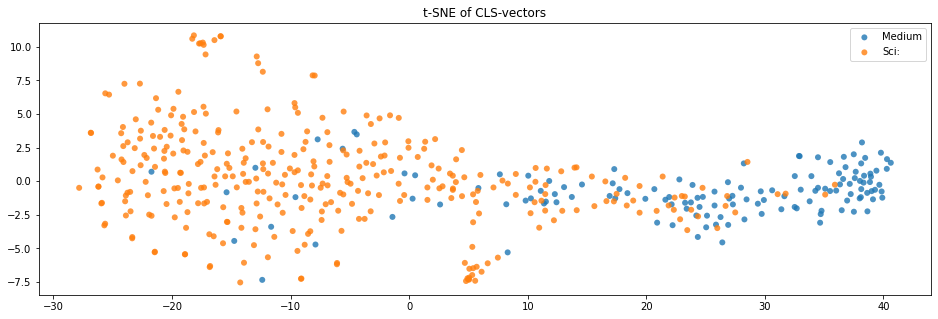

In [ ]:
cls_vecs = illustrate_cluster(dataframe = data, classifier = model_cluster, n_components = 2, names = {1: 'Sci:', 0: 'Medium'}, title = 't-SNE of CLS-vectors')

1) Cluster on left (majority CSArxiv)

In [ ]:
#Sci cluster
dislpay_sents_cluster(xmin = 7, xmax=20, ymin = -2.5, ymax=2.5, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 10)

2) General Medium Cluster
-

In [ ]:
#Sci cluster
dislpay_sents_cluster(xmin = 20, xmax=60, ymin = -40, ymax=40, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

3) Mixed Cluster


In [ ]:
#Report cluster
dislpay_sents_cluster(xmin =-40, xmax=20, ymin = -30, ymax=-20, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 100)

In [ ]:
#cluster
dislpay_sents_cluster(xmin =0, xmax=10, ymin = -10, ymax=20, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 40)

### Medium subclusters

4) Medium subcluster
  - Company/business
  - Jobs
  - Sci sents:
    - the optimum answer uses items and sizes from this list only. 
    - once the user clicks on a button which executes javascript

In [ ]:
#cluster
dislpay_sents_cluster(xmin =20, xmax=40, ymin = -60, ymax=-20, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 100)

5) Other Medium subcluster
  - extremely short sentences
  - endings
  


In [ ]:
#cluster
dislpay_sents_cluster(xmin =60, xmax=80, ymin = -60, ymax=0, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

6) Medium Subcluster
  - extremly short
  - no specific content
  - Sci: 
    - is data availability impossible? probably, no. 

In [ ]:
#cluster
dislpay_sents_cluster(xmin =12, xmax=22, ymin = 30, ymax=40, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

7) Medium Subclusters
- sentences with double colon at end


In [ ]:
#cluster
dislpay_sents_cluster(xmin =50, xmax=100, ymin = 10, ymax=80, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

8) Medium Subclusters
  - i

In [ ]:
#cluster
dislpay_sents_cluster(xmin =20, xmax=40, ymin = -20, ymax=-5, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 50)

9) Medium Subcluster
  - we/us sentences

In [ ]:
#cluster
dislpay_sents_cluster(xmin =12, xmax=25, ymin = -10, ymax=10, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

10) Medium subcluster


In [ ]:
#cluster
dislpay_sents_cluster(xmin =30, xmax=45, ymin = 0, ymax=20, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

11) Medium Subcluster
- You

In [ ]:
#cluster
dislpay_sents_cluster(xmin =40, xmax=60, ymin = -20, ymax=0, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

12) Medium Subcluster 
- short sentences no content fixed


In [ ]:
#cluster
dislpay_sents_cluster(xmin =20, xmax=50, ymin = 25, ymax=80, CLS_vecs=cls_vecs, all_sents=data['sent'], labels=data['true_label'], n_sents = 20)

## Manual Testing

In [ ]:
def test_manually(data, labels, tries = 100, rand_state = 42):
  testing_myself = 0

  data_ = [d for d in data]
  try:
    labels_ = [l.item() for l in list(labels)]
  except:
    labels_ = [l for l in list(labels)]

  query = random.Random(rand_state).sample(list(zip(data_,labels_)), tries)
  
  for i, (sent, label) in enumerate(query):
    print( f'{i}/{tries}' , sent, f'\t accuracy: { (testing_myself)/(i+1)}', '\n')
    a = input()
    a = int(a)
    if a == label:
      testing_myself +=1


  print(f'Accuracy: {testing_myself/tries:.2f}')
  return testing_myself/tries



In [ ]:
my_acc = test_manually(data_test, labels_test, 100, 12)

Accuracy on 100 sentences: 82%
Main decison making criteria:
  - style
  - use of certain phrases
  - complexity of vocabulary / content
  

## Checking paraphrases

In [ ]:
data_path = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/T5_paraphrases/'
filename_dataframe = 'data_paraphrased_F1_top75k.pkl'
paraphrase_data =  pd.read_pickle(data_path + filename_dataframe)

In [ ]:
originals = list(paraphrase_data['original'])
label_originals = [1 for _ in originals]
paraphrases = list(paraphrase_data['paraphrase'])
label_paraphrases = [0 for _ in paraphrases]

paraphrase_data_for_cluster = pd.DataFrame(columns = ['sent', 'true_label'])
paraphrase_data_for_cluster['sent'] = originals+paraphrases
paraphrase_data_for_cluster['true_label'] = label_originals+label_paraphrases
paraphrase_data_for_cluster.head()
paraphrase_loader = create_data_loader(paraphrase_data_for_cluster['sent'], paraphrase_data_for_cluster['true_label'], tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Calculation of relevant scores
labels_para_pred, labels_para_test,_ = get_predictions(model, paraphrase_loader)
report_para = classification_report(labels_para_test, labels_para_pred, output_dict=True)
report_para_df = pd.DataFrame(report_para).transpose()

In [ ]:
report_para_df

,precision,recall,f1-score,support
0,0.626693,0.216493,0.321815,75000.000000
1,0.526452,0.871040,0.656263,75000.000000
accuracy,0.543767,0.543767,0.543767,0.543767
macro avg,0.576573,0.543767,0.489039,150000.000000
weighted avg,0.576573,0.543767,0.489039,150000.000000


In [ ]:
cm_para = confusion_matrix(labels_para_test, labels_para_pred, normalize = 'true')
#show_confusion_matrix(cm_para, names = ['Paraphrase', 'Orig. Arxiv'], save_path=None)
cm_para

array([[0.21649333, 0.78350667],
       [0.12896   , 0.87104   ]])

## Reports

In [ ]:
data_path_reports = '/content/gdrive/MyDrive/StyleClassifier/datasets/almost_scientific_reports/final_processed/clean_report.txt'

with open(data_path_reports, 'r') as f:
  data_reports = f.readlines()

data_reports

In [ ]:
data_reports = [sent.lower().replace('\n','') for sent in data_reports]
data_reports

In [ ]:
labels_reports = [0 for _ in data_reports]
report_loader = create_data_loader(data_reports, labels_reports, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
labels_reports_pred, labels_reports_test,_ = get_predictions(model, report_loader)
report_reports = classification_report(labels_reports_test, labels_reports_pred, output_dict=True)
report_reports_df = pd.DataFrame(report_reports).transpose()
report_reports_df

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,0.550988,0.710499,1873.000000
1,0.000000,0.000000,0.000000,0.000000
accuracy,0.550988,0.550988,0.550988,0.550988
macro avg,0.500000,0.275494,0.355250,1873.000000
weighted avg,1.000000,0.550988,0.710499,1873.000000


## Checking ACL


In [ ]:
data_path_acl = 'gdrive/MyDrive/StyleClassifier/datasets/accepted_rejected/'
data_acl = pd.read_csv(data_path_acl+'sents_with_labels.csv')
data_acl

,Unnamed: 0,sents,labels,clarity
0,0,the first approach uses a neural language mode...,0,3.43
1,1,this model can effectively learn common poetic...,0,3.43
2,2,the second approach considers poetry generatio...,0,3.43
3,3,by manipulating the constraints of the latter ...,0,3.43
4,4,"in addition, participants rated a machinegener...",0,3.43
...,...,...,...,...
5984,5984,on the other textual classifier correctly dete...,1,5.00
5985,5985,contextual relationship among the utterances i...,1,5.00
5986,5986,"in this paper, we developed a lstm-based netwo...",1,5.00
5987,5987,the proposed method has outperformed the state...,1,5.00


In [ ]:
acl_loader = create_data_loader(data_acl['sents'], data_acl['labels'], tokenizer, MAX_LEN, BATCH_SIZE)
labels_acl_pred, labels_acl_test, acl_probs = get_predictions(model, acl_loader)

In [ ]:
report_acl = classification_report(labels_acl_test, labels_acl_pred, output_dict=True)
report_acl_df = pd.DataFrame(report_acl).transpose()
report_acl_df

,precision,recall,f1-score,support
0,0.458568,0.373103,0.411444,2833.000000
1,0.517915,0.604563,0.557895,3156.000000
accuracy,0.495074,0.495074,0.495074,0.495074
macro avg,0.488242,0.488833,0.484669,5989.000000
weighted avg,0.489842,0.495074,0.488619,5989.000000


In [ ]:
data_acl['pred_label']= labels_acl_pred
data_acl['prob_sci'] = [prob[1].item() for prob in acl_probs]
data_acl.head(10)

,Unnamed: 0,sents,labels,clarity,pred_label,prob_sci
0,0,the first approach uses a neural language mode...,0,3.43,0,-0.278324
1,1,this model can effectively learn common poetic...,0,3.43,0,-1.067347
2,2,the second approach considers poetry generatio...,0,3.43,0,0.214423
3,3,by manipulating the constraints of the latter ...,0,3.43,0,0.114518
4,4,"in addition, participants rated a machinegener...",0,3.43,1,1.219170
5,5,poetry is an advanced form of linguistic commu...,0,3.43,1,0.890888
6,6,as poetry is one of the most expressive forms ...,0,3.43,1,0.818059
7,7,in addition to requiring an understanding of m...,0,3.43,0,-0.937937
8,8,these rules may describe aspects of the litera...,0,3.43,1,2.303917
9,9,examples of different forms of poetry are lime...,0,3.43,1,0.450059


### Correlations with clarity score

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau

pearson_corr, pearson_p = pearsonr(data_acl['clarity'], data_acl['prob_sci'])
print(f'Pearson Correlation between Clarity and SciPrediction: { pearson_corr } ')

spearman_corr, spearman_p = spearmanr(data_acl['clarity'], data_acl['prob_sci'])
print(f'SpearmanCorrelation between Clarity and SciPrediction: { spearman_corr } ')

Pearson Correlation between Clarity and SciPrediction: -0.0004633745107841799 
SpearmanCorrelation between Clarity and SciPrediction: -0.00804734788604343 


# Results/Takeaways
